# Classic (numeric) preprocessing

Este notebook es una primera aproximación donde se preprocesará el dataset codificando numéricamente cada par de aminoacidos para en el siguiente notebook hacer el entrenamiento del modelo.

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [7]:
import pandas as pd

df_string_balanced = pd.read_parquet("../datasets/df_string_balanced.parquet")

In [8]:
df_string_balanced.head()

,protein1,protein2,label,sequence1,sequence2
0,9606.ENSP00000000233,9606.ENSP00000257770,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MCPRAARAPATLLLALGAVLWPAAGAWELTILHTNDVHSRLEQTSE...
1,9606.ENSP00000000233,9606.ENSP00000226004,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSGSFELSVQDLNDLLSDGSGCYSLPSQPCNEVTPRIYVGNASVAQ...
2,9606.ENSP00000000233,9606.ENSP00000262455,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MHPAVFLSLPDLRCSLLLLVTWVFTPVTTEITSLDTENIDEILNNA...
3,9606.ENSP00000000233,9606.ENSP00000263265,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MEGSRPRSSLSLASSASTISSLSSLSPKKPTRAVNKIHAFGKRGNA...
4,9606.ENSP00000000233,9606.ENSP00000365686,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MGMSKSHSFFGYPLSIFFIVVNEFCERFSYYGMRAILILYFTNFIS...


## Sequence encoding

Antes de codificar y preparar las secuencias proteicas como entrada al modelo, tenemos que determinar una longitud máxima (`max_length`) para todas ellas. Los modelos de deep learning, especialmente aquellos que trabajan con batches, requieren entradas de tamaño fijo.

Para definir un `max_length` adecuado, analizaremos la distribución de longitudes de todas las secuencias de proteínas involucradas en los pares del dataset. Esto nos permitirá encontrar un equilibrio entre:

- Maximizar la cobertura (evitar truncar demasiadas secuencias)
- Minimizar el uso de memoria y el tiempo de entrenamiento

count    3.657310e+06
mean     6.111922e+02
std      6.521871e+02
min      2.500000e+01
25%      2.760000e+02
50%      4.570000e+02
75%      7.390000e+02
max      3.599100e+04
dtype: float64
Cuantiles:
0.50     457.0
0.75     739.0
0.90    1174.0
0.95    1622.0
0.99    2839.0
dtype: float64


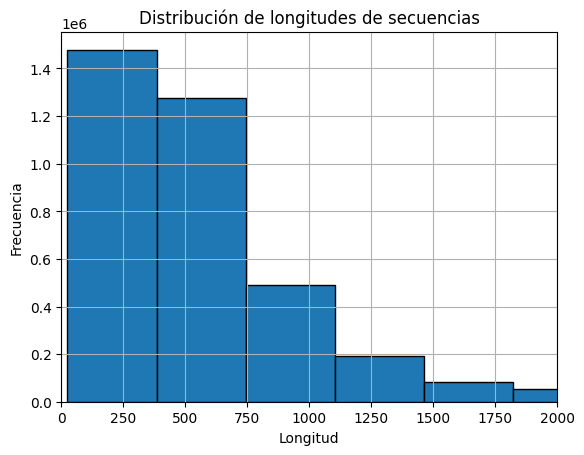

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df_string_balanced["len_seq1"] = df_string_balanced["sequence1"].str.len()
df_string_balanced["len_seq2"] = df_string_balanced["sequence2"].str.len()

lengths = pd.concat([df_string_balanced["len_seq1"], df_string_balanced["len_seq2"]])

print(lengths.describe())
print("Cuantiles:")
print(lengths.quantile([0.5, 0.75, 0.90, 0.95, 0.99]))

plt.hist(lengths, bins=100, edgecolor="black")
plt.title("Distribución de longitudes de secuencias")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

El histograma muestra que la gran mayoría de las secuencias tienen una longitud inferior a 1000 aminoácidos. En concreto, los percentiles calculados reflejan que:

- El 90 % de las secuencias tienen ≤ 1174 aminoácidos
- El 95 % tienen ≤ 1622
- El 99 % tienen ≤ 2839

Basándonos en esta distribución, se ha decidido establecer un `max_length` de **1024**. Este valor permite cubrir hasta casi el 90 % de las secuencias sin truncamiento, al tiempo que mantiene un consumo de memoria razonable compatible con la GPU disponible. Las secuencias más largas serán truncadas para ajustarse a esta longitud, mientras que las más cortas serán completadas mediante padding.

In [10]:
df_string_balanced.drop(columns=["len_seq1", "len_seq1"], inplace=True)

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [4]:
from computation.azure_compute_platform import AzureComputePlatform
from computation.job_type import JobType

compute = AzureComputePlatform(
    subscription_id  = os.environ["AZURE_SUBSCRIPTION_ID"],
    resource_group   = os.environ["AZURE_RESOURCE_GROUP"],
    workspace_name   = os.environ["AZURE_WORKSPACE_NAME"],
    compute_name     = os.environ["AZURE_COMPUTE"],
    environment_name = os.environ["AZURE_ENVIRONMENT"],
)

input_name = "ppi_balanced"
input_version = "1"
output_name = "numerical_preprocessed_sequences"

job_id = compute.queue_job(
    job_type=JobType.PREPROCESS,
    input_name=input_name,
    input_version=input_version,
    output_name=output_name,
)

print(f"Job launched: {job_id}")

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Uploading src (0.03 MBs): 100%|██████████| 31028/31028 [00:00<00:00, 170457.91it/s]




Job launched: purple_corn_0y8n52t4n1


### Conclusión del preprocesamiento

En este notebook se ha llevado a cabo el preprocesamiento completo del dataset de interacciones proteína-proteína (PPI) con evidencia experimental directa, extraído de la base de datos STRING.

El proceso incluyó la asociación de secuencias de aminoácidos mediante identificadores Ensembl, la codificación numérica de las secuencias con una longitud máxima de 1024 residuos, y el etiquetado binario de las interacciones (positivas y negativas). Para ello se implementaron clases reutilizables siguiendo principios de diseño limpio y modular, como `SequencePreprocessor` y `SequenceEncoder`.

El resultado final es un archivo en formato `.parquet` que contiene los datos preprocesados y balanceados, listos para ser utilizados en la fase de entrenamiento del modelo de deep learning. Este enfoque desacopla el procesamiento de datos del entrenamiento, facilitando futuras pruebas con distintos modelos y codificadores sin necesidad de repetir esta etapa.
